<a href="https://colab.research.google.com/github/imdeepmind/Girls/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1.0 Preparing the Development Environment

In [5]:
# Installing pytorch, torchvision, and matplotlib
!pip install torch torchvision matplotlib

# Connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Making dirs
!mkdir dataset

# Copying the file from Google Drive
!cp 'drive/My Drive/dataset/girls/images.zip' .

# Extracting the file
!unzip -qq images.zip -d 'dataset/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!ls dataset/images

faces


## 2.0 Constants

In [0]:
DATASET = 'dataset/images'
BATCH_SIZE = 32
IMAGE_SIZE = 64
EPOCHS = 2
LENGTH_Z = 100
LENGTH_FEATURE_MAP_G = 64
LENGTH_FEATURE_MAP_D = 64

## 3.0 Loaing the Dataset

In [0]:
# Importing dependencies
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [0]:
# Data Transforms
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


images = datasets.ImageFolder(DATASET, transform=transform)

imageLoader = DataLoader(images, batch_size=BATCH_SIZE, shuffle=True)

## 4.0 Exploring the Dataset

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

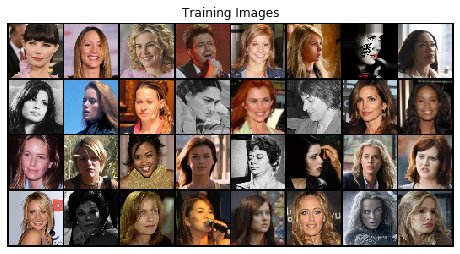

In [20]:
# Plot some training images
real_batch = next(iter(imageLoader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))

## 5.0 Hardware Configurations

In [0]:
import torch

In [23]:
# Checking the available device (gpu or cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Running the model in', device.type)

Running the model in cuda


## 6.0 Generator 

In [0]:
import torch 
import torch.nn as nn

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(LENGTH_Z, LENGTH_FEATURE_MAP_G * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_G * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(LENGTH_FEATURE_MAP_G * 8, LENGTH_FEATURE_MAP_G * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_G * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(LENGTH_FEATURE_MAP_G * 4, LENGTH_FEATURE_MAP_G * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_G * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(LENGTH_FEATURE_MAP_G * 2, LENGTH_FEATURE_MAP_G, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(LENGTH_FEATURE_MAP_G, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)

In [39]:
generator = Generator().to(device)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## 7.0 Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, LENGTH_FEATURE_MAP_D, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(LENGTH_FEATURE_MAP_D, LENGTH_FEATURE_MAP_D * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_D * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(LENGTH_FEATURE_MAP_D * 2, LENGTH_FEATURE_MAP_D, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_D * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(LENGTH_FEATURE_MAP_D * 4, LENGTH_FEATURE_MAP_D * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(LENGTH_FEATURE_MAP_D * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(LENGTH_FEATURE_MAP_D * 8, 1, 4, 2, 1, bias=False),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.main(x)

In [40]:
discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## 8.0 Loss Functions and Optimizers

In [0]:
import torch.nn as nn
import torch.optim as optimizer

In [0]:
## Loss Function
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Optimizers
optimizerG = optimizer.Adam(generator.parameters())
optimizerD = optimizer.Adam(discriminator.parameters())

## 9.0 Training the Model

In [50]:
for i in range(EPOCHS):
    for data in imageLoader:
        print(data[0], data[1])
        break

tensor([[[[ 0.6784,  0.6549,  0.6706,  ...,  0.0588,  0.0510,  0.0510],
          [ 0.6627,  0.6392,  0.6706,  ...,  0.0588,  0.0510,  0.0431],
          [ 0.6471,  0.6235,  0.6627,  ...,  0.0510,  0.0510,  0.0510],
          ...,
          [-0.6706, -0.6706, -0.6863,  ...,  0.2235,  0.2235,  0.2157],
          [-0.6863, -0.6784, -0.6941,  ...,  0.4275,  0.4275,  0.4118],
          [-0.6706, -0.6627, -0.6784,  ...,  0.5373,  0.5373,  0.5137]],

         [[ 0.4980,  0.4667,  0.4824,  ..., -0.2000, -0.1922, -0.1765],
          [ 0.4824,  0.4510,  0.4824,  ..., -0.2314, -0.2235, -0.2157],
          [ 0.4667,  0.4431,  0.4745,  ..., -0.2627, -0.2627, -0.2627],
          ...,
          [-0.7647, -0.7647, -0.7647,  ...,  0.0510,  0.0588,  0.0667],
          [-0.7961, -0.7725, -0.7725,  ...,  0.2549,  0.2627,  0.2627],
          [-0.7804, -0.7569, -0.7569,  ...,  0.3647,  0.3725,  0.3647]],

         [[ 0.2314,  0.1843,  0.2000,  ..., -0.6000, -0.6157, -0.6157],
          [ 0.2157,  0.1686,  